# Darts

In [1]:
pip install darts

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from darts import TimeSeries

In [3]:
# import csv dataset
df=pd.read_csv('aggregate_trip_duration_date.csv',delimiter=",")
df=pd.DataFrame(df)
df=df.dropna()
df=df.sort_values("date")

In [4]:
df

,date,trip_duration
0,2013-06-30,146356
1,2013-07-01,202276
2,2013-07-02,176217
3,2013-07-03,52708
4,2013-07-04,422040
...,...,...
278,2014-07-24,786595
279,2014-07-25,645473
280,2014-07-26,1138950
281,2014-07-27,896083


In [6]:
series = TimeSeries.from_dataframe(df, "date", "trip_duration", fill_missing_dates=True, freq=None)

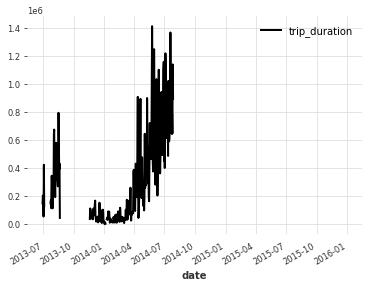

In [7]:
series.plot()